<h1>Load Dataset and Setup</h1>

In [1]:
import torch
torch.set_num_threads(4)           
torch.set_num_interop_threads(4)

import pandas as pd
import json
import os


csv_path = os.path.join('../data', 'spotify_dataset.csv')
json1_path = os.path.join('../data', '900k Definitive Spotify Dataset.json')
json2_path = os.path.join('../data', 'final_milliondataset_BERT_500K_revised.json')

try:
    df_csv = pd.read_csv(csv_path, low_memory=False)
    print(f"CSV loaded with {len(df_csv)} rows and {len(df_csv.columns)} columns\n")
except Exception as e:
    print(f"Error loading CSV: {e}")

print("CSV dataset info:")
display(df_csv.info())
print("\nCSV dataset sample:")
display(df_csv.head())

print("\nLoading first JSON dataset sample (first 1000 records)...")
try:
    with open(json1_path, 'r', encoding='utf-8') as f:
        data_json1 = []
        for i, line in enumerate(f):
            if i >= 1000:
                break
            data_json1.append(json.loads(line))
    print(f"Loaded {len(data_json1)} JSON records from first file\n")
except Exception as e:
    print(f"Error loading JSON 1: {e}")

if len(data_json1) > 0:
    print("Keys in one JSON record:")
    display(data_json1[0].keys())
    print("\nSample JSON record:")
    display(data_json1[0])

try:
    with open(json2_path, 'r', encoding='utf-8') as f:
        data_json2 = []
        for i, line in enumerate(f):
            if i >= 1000:
                break
            data_json2.append(json.loads(line))
    print(f"Loaded {len(data_json2)} JSON records from first file\n")
except Exception as e:
    print(f"Error loading JSON 1: {e}")

if len(data_json2) > 0:
    print("Keys in one JSON record:")
    display(data_json2[0].keys())
    print("\nSample JSON record:")
    display(data_json2[0])

CSV loaded with 551443 rows and 39 columns

CSV dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551443 entries, 0 to 551442
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Artist(s)                       551443 non-null  object 
 1   song                            551427 non-null  object 
 2   text                            551443 non-null  object 
 3   Length                          551443 non-null  object 
 4   emotion                         551443 non-null  object 
 5   Genre                           551443 non-null  object 
 6   Album                           551391 non-null  object 
 7   Release Date                    551443 non-null  object 
 8   Key                             551443 non-null  object 
 9   Tempo                           551443 non-null  int64  
 10  Loudness (db)                   551443 non-null  object 
 11  Time signature  

None


CSV dataset sample:


,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,03:47,sadness,hip hop,Thr!!!er,29th April 2013,D min,105,...,0,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",04:03,sadness,hip hop,Thr!!!er,29th April 2013,A# min,117,...,0,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",05:51,joy,hip hop,Louden Up Now,8th June 2004,A Maj,121,...,0,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752
3,!!!,Ooo,[Verse 1] Remember when I called you on the te...,03:44,joy,hip hop,As If,16th October 2015,A min,122,...,0,Eric Clapton,Man Overboard,0.992749,Roxette,Don't Believe In Accidents,0.991494,Tiwa Savage,My Darlin,0.990381
4,!!!,Freedom 15,[Verse 1] Calling me like I got something to s...,06:00,joy,hip hop,As If,16th October 2015,F min,123,...,0,Cibo Matto,Lint Of Love,0.981610,Barrington Levy,Better Than Gold,0.981524,Freestyle,Its Automatic,0.981415



Loading first JSON dataset sample (first 1000 records)...
Loaded 1000 JSON records from first file

Keys in one JSON record:


dict_keys(['Artist(s)', 'song', 'text', 'Length', 'emotion', 'Genre', 'Album', 'Release Date', 'Key', 'Tempo', 'Loudness (db)', 'Time signature', 'Explicit', 'Popularity', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Liveness', 'Acousticness', 'Instrumentalness', 'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation', 'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine', 'Similar Songs'])


Sample JSON record:


{'Artist(s)': '!!!',
 'song': 'Even When the Waters Cold',
 'text': 'Friends told her she was better off at the bottom of a river Than in a bed with him He said "Until you try both, you won\'t know what you like better Why don\'t we go for a swim?" Well, friends told her this and friends told her that But friends don\'t choose what echoes in your head When she got bored with all the idle chit-and-chat Kept thinking \'bout what he said I\'ll swim even when the water\'s cold That\'s the one thing that I know Even when the water\'s cold She remembers it fondly, she doesn\'t remember it all But what she does, she sees clearly She lost his number, and he never called But all she really lost was an earring The other\'s in a box with others she has lost I wonder if she still hears me I\'ll swim even when the water\'s cold That\'s the one thing that I know Even when the water\'s cold If you believe in love You know that sometimes it isn\'t Do you believe in love? Then save the bullshit questio

Loaded 1000 JSON records from first file

Keys in one JSON record:


dict_keys(['Artist(s)', 'song', 'text', 'Length', 'emotion', 'ISRC', 'Genre', 'Album', 'Release Date', 'Key', 'Tempo', 'Loudness (db)', 'Time signature', 'Song Number', 'Explicit', 'Popularity', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Liveness', 'Acousticness', 'Instrumentalness', 'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation', 'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine', 'Similar Songs'])


Sample JSON record:


{'Artist(s)': '!!!',
 'song': 'Even When the Waters Cold',
 'text': 'Friends told her she was better off at the bottom of a river\nThan in a bed with him\nHe said "Until you try both, you won\'t know what you like better\nWhy don\'t we go for a swim?"\nWell, friends told her this and friends told her that\nBut friends don\'t choose what echoes in your head\nWhen she got bored with all the idle chit-and-chat\nKept thinking \'bout what he said\n\nI\'ll swim even when the water\'s cold\nThat\'s the one thing that I know\nEven when the water\'s cold\n\nShe remembers it fondly, she doesn\'t remember it all\nBut what she does, she sees clearly\nShe lost his number, and he never called\nBut all she really lost was an earring\nThe other\'s in a box with others she has lost\nI wonder if she still hears me\n\nI\'ll swim even when the water\'s cold\nThat\'s the one thing that I know\nEven when the water\'s cold\nIf you believe in love\nYou know that sometimes it isn\'t\nDo you believe in love?\nT

In [2]:
# For BERT
import sys
print(sys.executable)
print(torch.cuda.is_available())

/home/jack/Desktop/spotify-lyrical-analysis/venv/bin/python
True


<h1>Dataset Cleaning and Preprocessing</h1>

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Merged dataset size: (553443, 16)
emotion
joy        189655
sadness    157185
anger       96062
Name: count, dtype: int64
After cleaning:


,text,emotion,genre,key,tempo,loudness_db,time_signature,explicit,popularity,energy,danceability,positiveness,speechiness,liveness,acousticness,instrumentalness
0,Friends told her she was better off at the bot...,sadness,hip hop,D min,105.0,-6.85,4/4,0,40,83,71,87,4,16,11,0
1,"Well I heard it, playing soft From a drunken b...",sadness,hip hop,A# min,117.0,-5.75,4/4,0,42,85,70,87,4,32,0,0
2,"Oh my god, did I just say that out loud? Shoul...",joy,hip hop,A Maj,121.0,-6.06,4/4,0,29,89,71,63,8,64,0,20
3,[Verse 1] Remember when I called you on the te...,joy,hip hop,A min,122.0,-5.42,4/4,0,24,84,78,97,4,12,12,0
4,[Verse 1] Calling me like I got something to s...,joy,hip hop,F min,123.0,-5.57,4/4,0,30,71,77,70,7,10,4,1


,tempo,loudness_db,explicit,popularity,energy,danceability,positiveness,speechiness,liveness,acousticness,instrumentalness
count,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000
mean,120.660059,-8.048557,0.289604,30.479449,63.026198,58.490005,47.103585,11.620234,19.847761,25.665529,7.304526
std,29.756910,4.006575,0.453579,17.206086,22.559058,17.384143,24.059627,12.415717,16.338213,29.382087,20.674488
min,0.201183,-50.060000,0.000000,0.000000,0.000000,6.000000,0.000000,2.000000,1.000000,0.000000,0.000000
25%,97.000000,-9.870000,0.000000,18.000000,48.000000,47.000000,28.000000,4.000000,10.000000,2.000000,0.000000
50%,120.000000,-7.210000,0.000000,28.000000,65.000000,59.000000,46.000000,6.000000,13.000000,12.000000,0.000000
75%,140.000000,-5.360000,1.000000,40.000000,81.000000,72.000000,66.000000,15.000000,25.000000,43.000000,0.000000
max,200.000000,4.980000,1.000000,100.000000,100.000000,99.000000,100.000000,97.000000,100.000000,100.000000,100.000000


emotion
joy        189655
sadness    157185
anger       96062
Name: count, dtype: int64
genre
hip hop                             188207
pop                                   8982
country                               6458
folk                                  4318
jazz                                  3306
rap,hip hop                           3118
rock,pop,alternative rock             3117
soul                                  3093
hip hop,trap                          3085
rock                                  3047
rap,hip hop,trap                      2789
trap                                  2696
rock,heavy metal,metal                2469
rock,alternative rock,indie rock      2355
reggae                                2339
rock,alternative rock,punk            2141
indie rock                            2093
rap,hip-hop,hip hop                   1955
indie pop                             1683
punk                                  1592
Name: count, dtype: int64


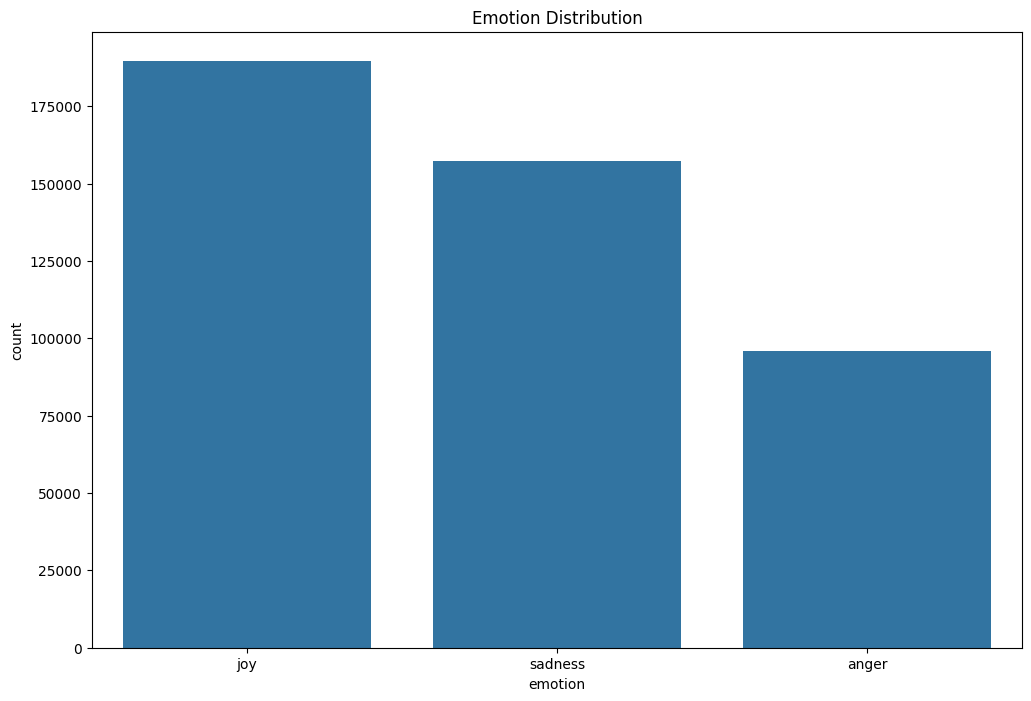

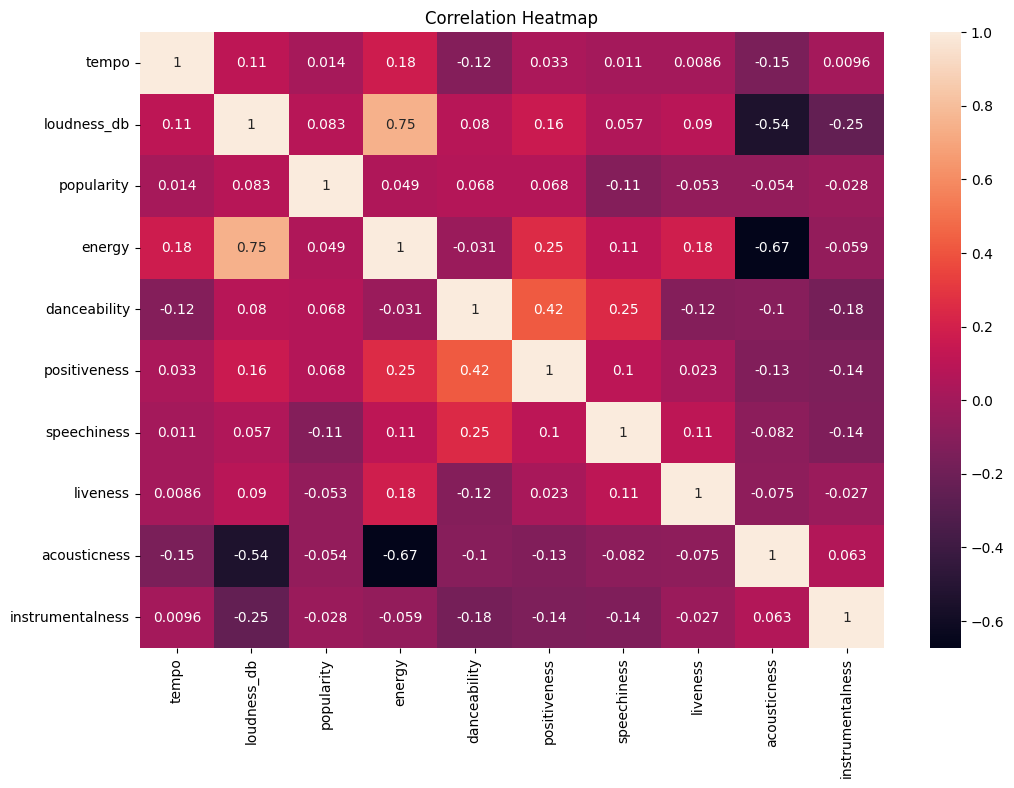

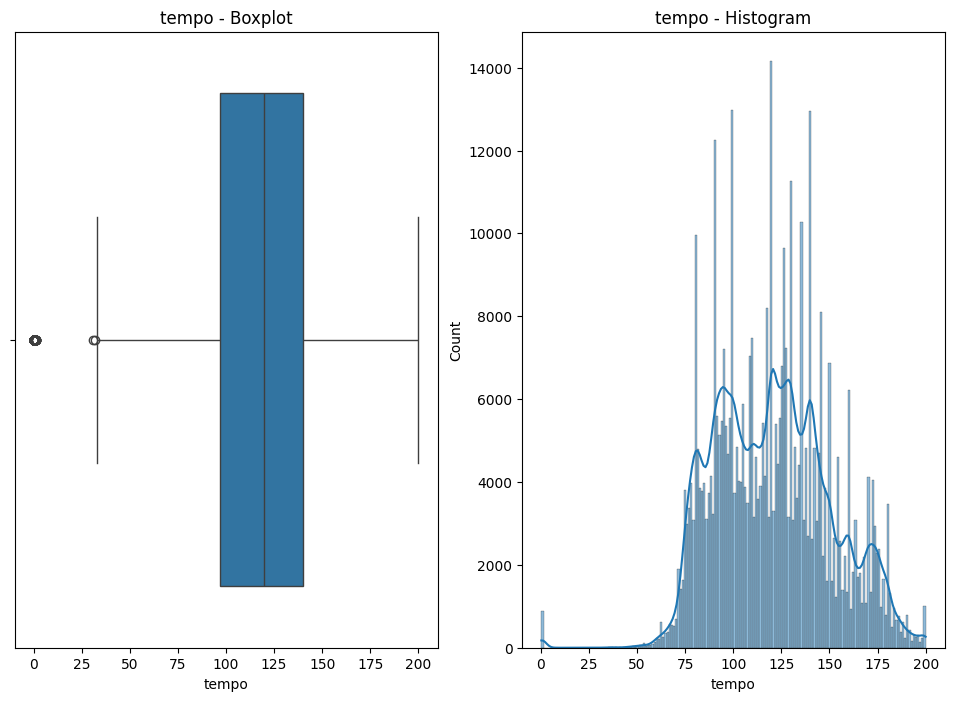

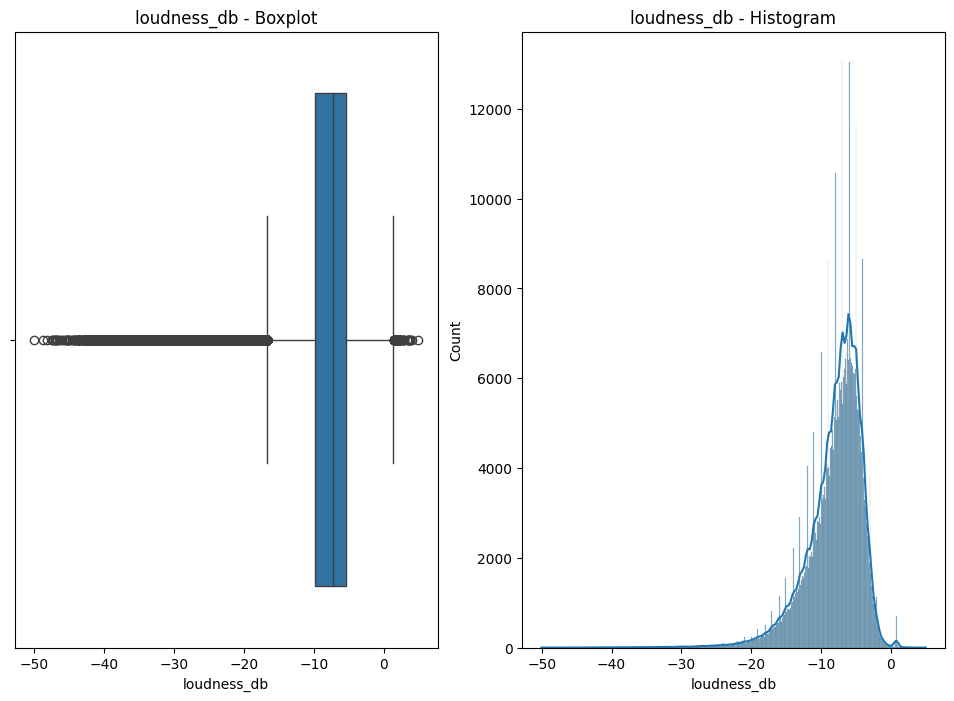

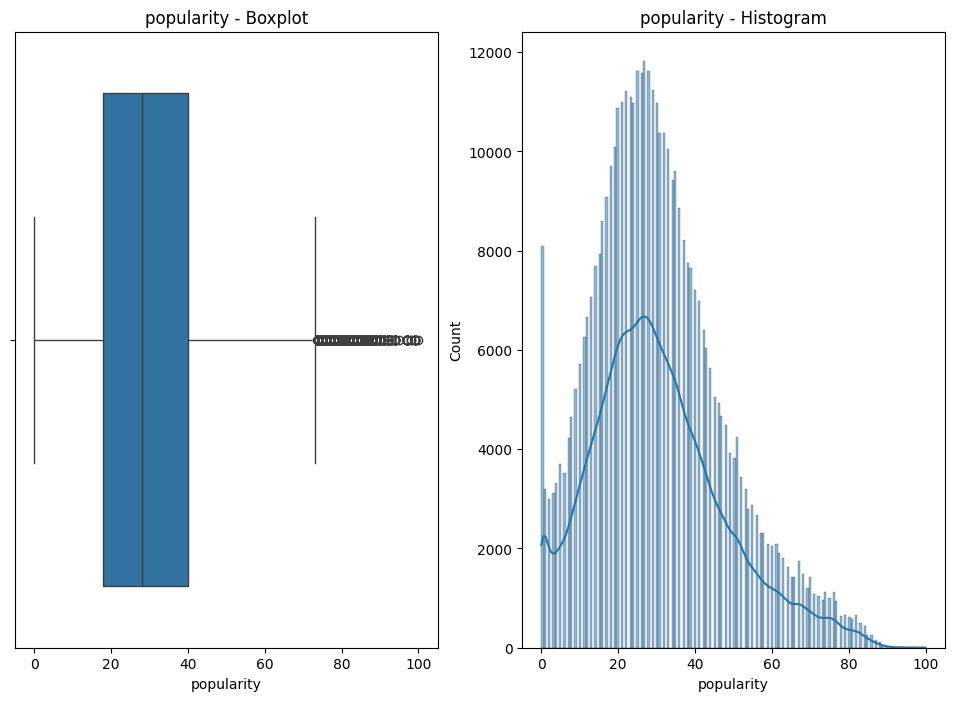

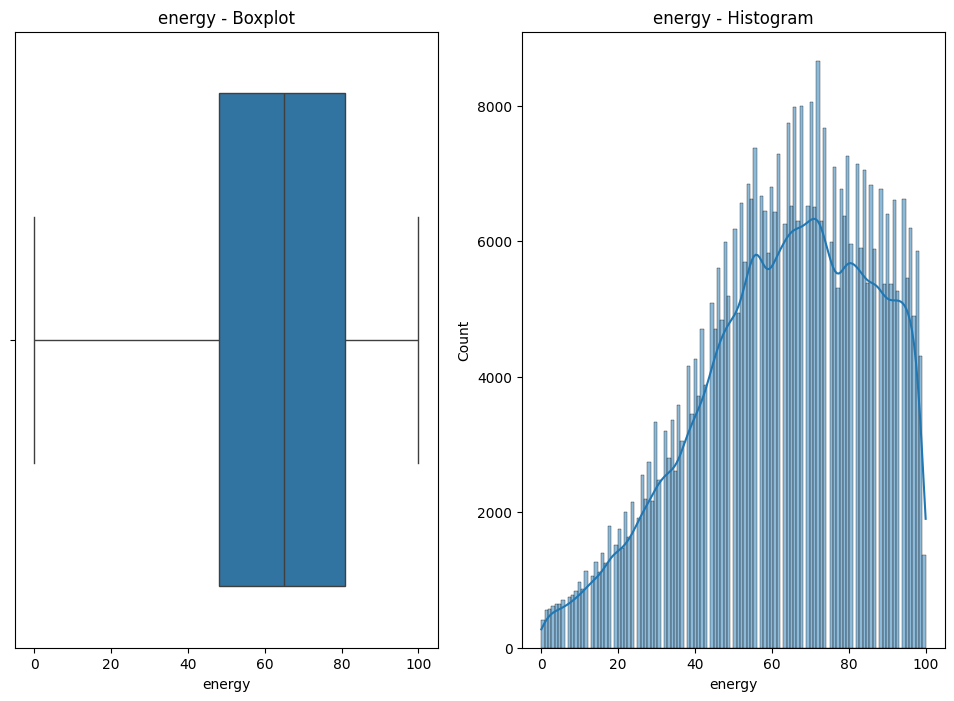

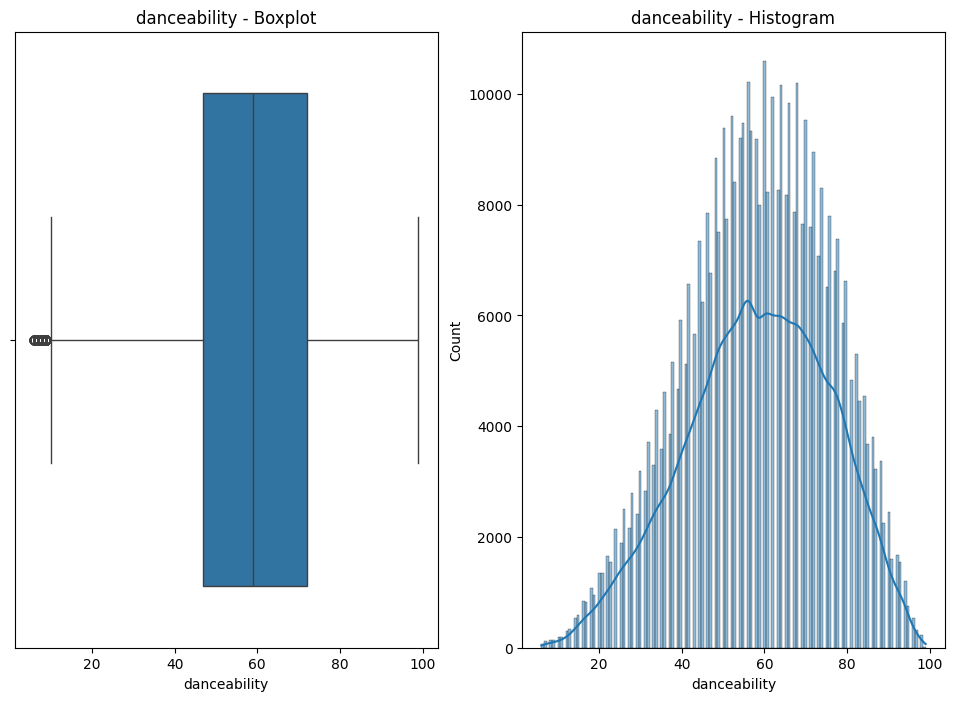

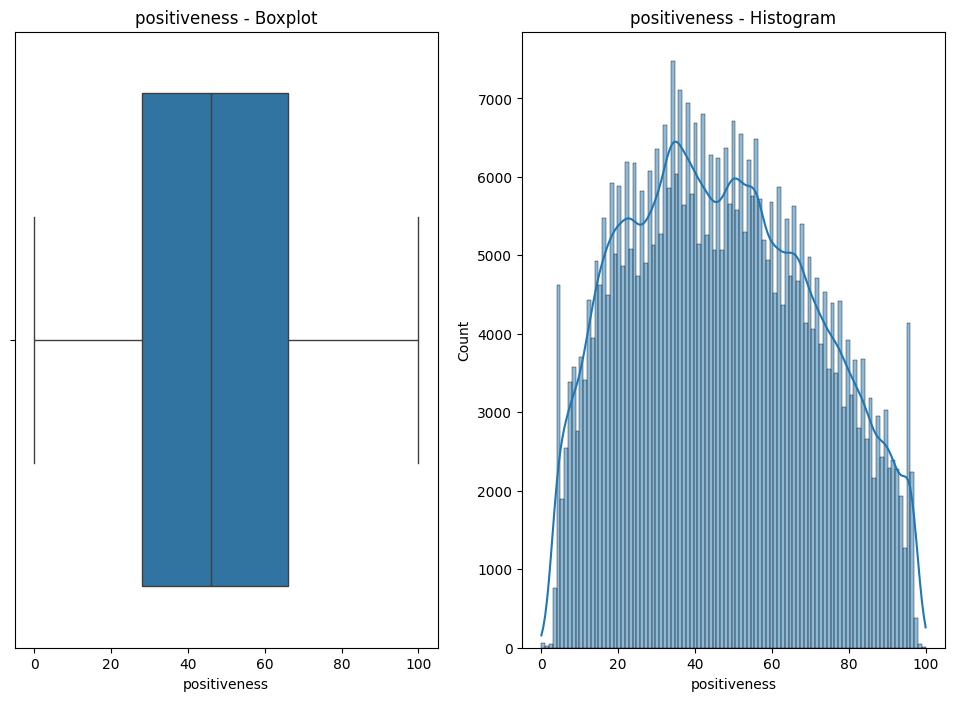

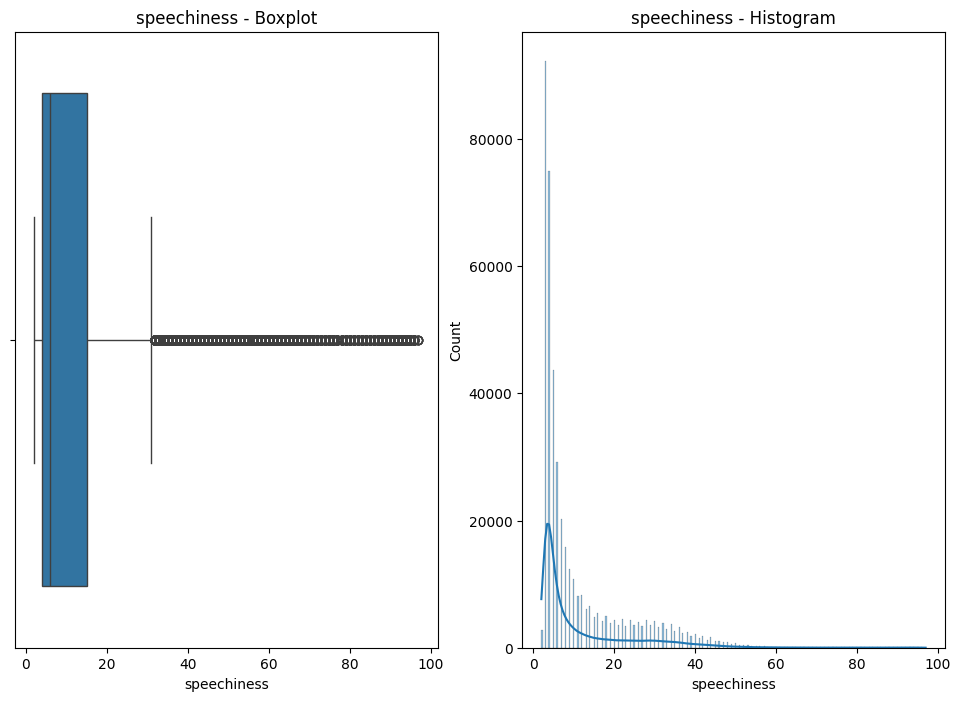

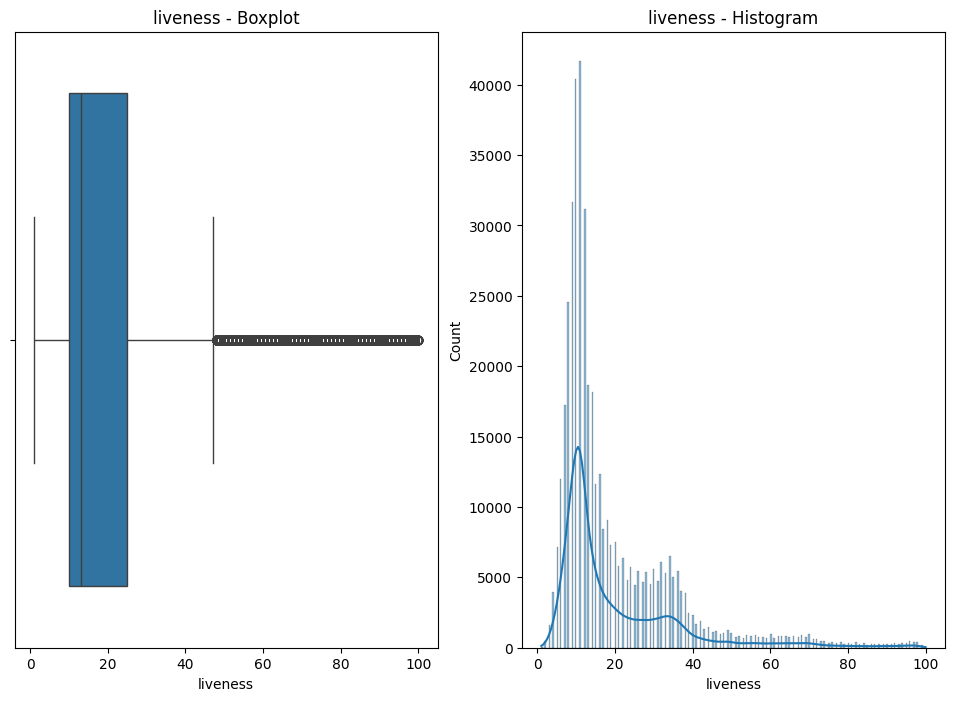

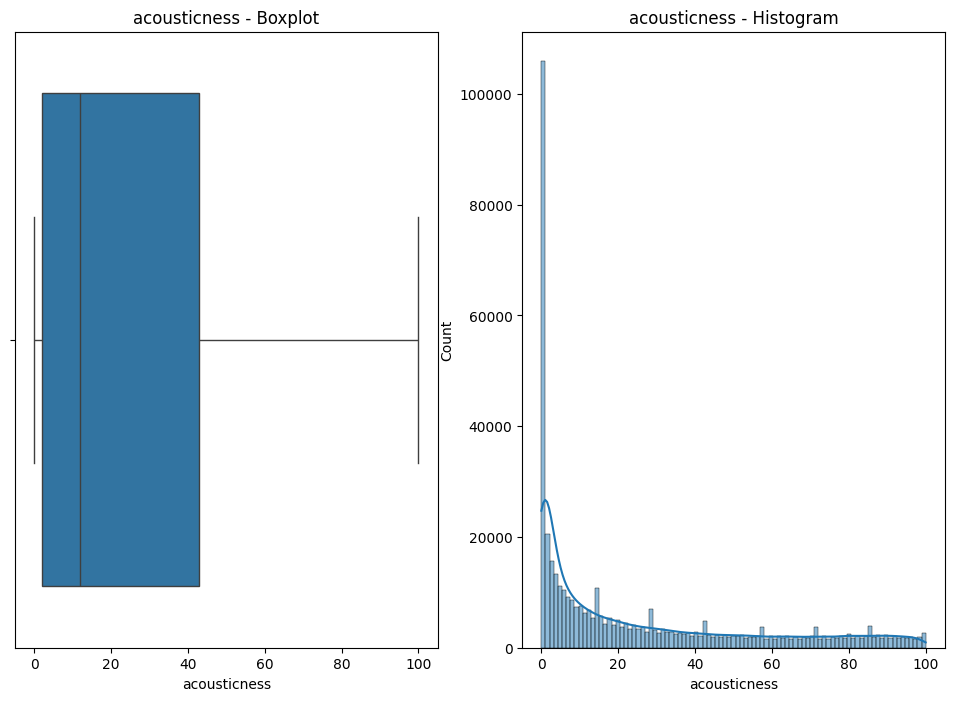

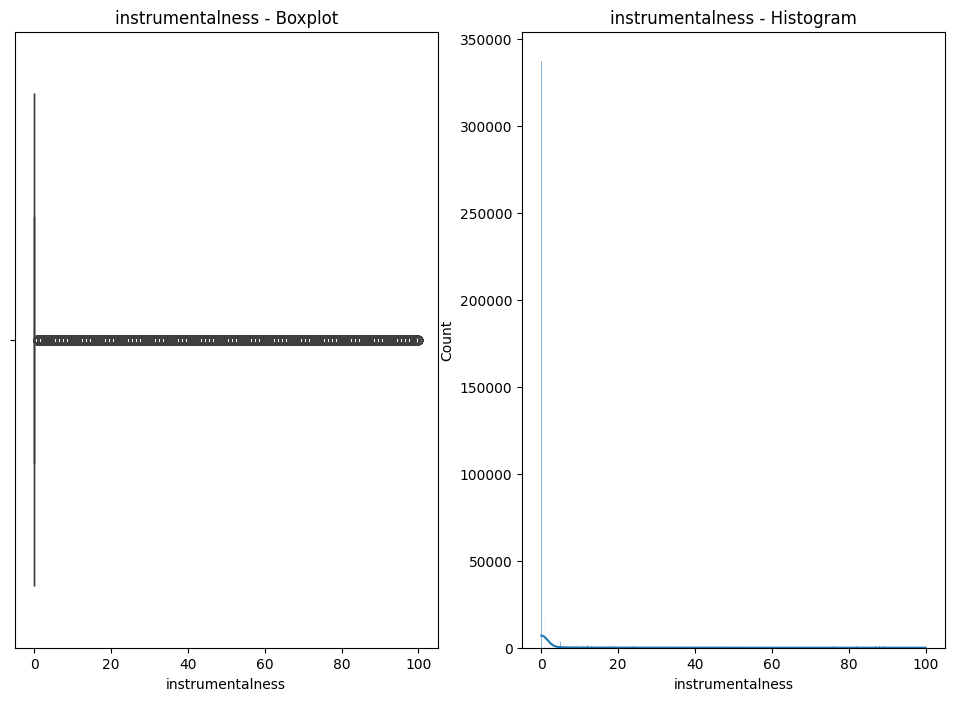

tempo: 881 outliers
loudness_db: 14938 outliers
popularity: 9250 outliers
energy: 0 outliers
danceability: 457 outliers
positiveness: 0 outliers
speechiness: 41936 outliers
liveness: 29885 outliers
acousticness: 0 outliers
instrumentalness: 105815 outliers
Sampled dataset size: (150000, 16)
emotion
anger      50000
joy        50000
sadness    50000
Name: count, dtype: int64
Dataframe after merging VADER: (150000, 20)


,vader_neg,vader_neu,vader_pos,vader_compound
count,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.112399,0.757946,0.129657,0.080878
std,0.077084,0.094522,0.078142,0.900272
min,0.000000,0.000000,0.000000,-1.000000
25%,0.055000,0.701000,0.077000,-0.968600
50%,0.100000,0.763000,0.115000,0.527550
75%,0.155000,0.822000,0.166000,0.979300
max,0.945000,1.000000,1.000000,1.000000


Emotion mapping (label : emotion):
{np.int64(0): 'anger', np.int64(1): 'joy', np.int64(2): 'sadness'}
After extracting first genre: 88 unique values
Dataframe after encoding:



,text,emotion,tempo,loudness_db,explicit,popularity,energy,danceability,positiveness,speechiness,...,key_F# Maj,key_F# min,key_G Maj,key_G min,key_G# Maj,key_G# min,ts_1/4,ts_3/4,ts_4/4,ts_5/4
0,"[Hook] I'm on that sand, man Sandman, I'm on t...",anger,142.0,-12.16,0,52,26,39,88,6,...,False,False,False,False,False,False,False,True,False,False
1,[Chorus: Gotye (Sampled)] Your heart's a mess ...,anger,128.0,-16.83,0,39,20,92,78,10,...,False,False,False,False,False,False,False,False,True,False
2,"[Chorus] Had to shoot your mans, I had no opti...",anger,146.0,-10.68,1,16,61,81,86,20,...,False,False,False,False,False,False,False,False,True,False
3,[Intro: sample (P.R. Terrorist)] For security ...,anger,91.0,-7.40,1,22,58,62,64,30,...,False,True,False,False,False,False,False,False,True,False
4,[Intro] (M3nace) (Senseii) [Chorus] Two in a ...,anger,142.0,-8.41,1,25,60,90,51,41,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,[Verse 1] Waiting for the morning sun Are you ...,sadness,91.0,-7.27,0,38,60,64,16,3,...,True,False,False,False,False,False,False,False,True,False
149996,Rows of houses all bearing down on me I can...,sadness,136.0,-20.14,0,16,7,27,5,4,...,False,False,False,False,False,False,False,False,True,False
149997,It's a shame you have a mind of your own now. ...,sadness,128.0,-8.16,0,23,87,41,34,6,...,False,False,False,False,False,False,False,False,True,False
149998,With a little bit of common sense You can lose...,sadness,177.0,-5.01,1,26,97,31,76,6,...,False,False,False,False,False,False,False,False,True,False


Dataframe after adding BERT embeddings:(149999, 85)


'#Scale features\nbert_cols = [c for c in X_train.columns if c.startswith(\'bert_\')]\nother_cols = [c for c in X_train.columns if not c.startswith(\'bert_\')]\nall_numeric_cols = numeric_cols + bert_cols\nscaler = RobustScaler()\nX_train_scaled = X_train.copy()\nX_test_scaled = X_test.copy()\n\n#X_train_scaled[all_numeric_cols] = scaler.fit_transform(X_train[all_numeric_cols])\n#X_test_scaled[all_numeric_cols] = scaler.transform(X_test[all_numeric_cols])\n\nX_train_scaled = X_train_scaled.fillna(0)\nX_test_scaled = X_test_scaled.fillna(0)\n\n# So that the code runs without feature selection for now\nX_train_final = X_train_scaled.copy()\nX_test_final = X_test_scaled.copy()\n\n"""\n#PCA to select 100 best BERT features\npca = PCA(n_components=100, random_state=42)\n\nX_train_bert_pca = pca.fit_transform(X_train_scaled[bert_cols])\nX_test_bert_pca = pca.transform(X_test_scaled[bert_cols])\n\nbert_pca_cols = [f\'bert_pca_{i}\' for i in range(100)]\nX_train_bert_pca_df = pd.DataFrame(X_tr

In [3]:
from pyexpat import model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

#Convert to dataframes
df_json1 = pd.DataFrame(data_json1)
df_json2 = pd.DataFrame(data_json2)

#Standardize column names
def clean_col(df):
    df.columns = (df.columns.
                  str.strip().
                  str.lower().
                  str.replace(" ", "_").
                  str.replace("(", "").
                  str.replace(")", "").
                  str.replace("/", "_")
    )
    return df

df_csv = clean_col(df_csv)
df_json1 = clean_col(df_json1)
df_json2 = clean_col(df_json2)

#Columns that all 3 share and will be used for regression
common_cols = [
    "text", "emotion", "genre", "key", "tempo", "loudness_db", "time_signature", "explicit", "popularity", "energy", "danceability", 
    "positiveness", "speechiness", "liveness", "acousticness", "instrumentalness"
]

#Keep only available columns
df_csv = df_csv[[c for c in common_cols if c in df_csv.columns]]
df_json1 = df_json1[[c for c in common_cols if c in df_json1.columns]]
df_json2 = df_json2[[c for c in common_cols if c in df_json2.columns]]

#Merge the three datasets
df = pd.concat([df_csv, df_json1, df_json2], ignore_index=True)
print(f"Merged dataset size: {df.shape}")

df = df.drop_duplicates(subset=["text"])
df = df[df["text"].notna() & (df["text"].str.len() > 20)]  #Min length
df = df[df["text"].str.split().str.len() >= 15]  #More words required

#Clean numeric columns and convert types
numeric_cols = [
    "tempo", "loudness_db", "popularity", "energy", "danceability", "positiveness", "speechiness", "liveness", "acousticness", "instrumentalness"
]

#Keep only the db value, remove unit
if "loudness_db" in df.columns:
    df["loudness_db"] = (
        df["loudness_db"]
        .astype(str)            
        .str.replace("db", "")  #remove 'db'
        .str.strip()            #remove extra spaces
    )
    df["loudness_db"] = pd.to_numeric(df["loudness_db"], errors="coerce")

#Convert all the columns into numeric
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

#Map explicit to 1 or 0
df["explicit"] = df["explicit"].map({"Yes": 1, "No": 0})
df["explicit"] = df["explicit"].fillna(0)

#Drop rows missing emotion label - target
df = df[df["emotion"].notna()]
# Normalize emotion labels
df['emotion'] = df['emotion'].str.lower().str.strip()
#Keep only joy, sadness, anger
keep_emotions = ['joy', 'sadness', 'anger']
df = df[df['emotion'].isin(keep_emotions)]
print(df['emotion'].value_counts())


#Drop rows missing >30% numeric features
df.dropna(subset=numeric_cols, thresh=8, inplace=True)

#Fill missing values with median
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())
        # df[col].fillna(df[col].median(), inplace=True)

print("After cleaning:")
display(df.head())
#Data exploration
display(df.describe())
print(df["emotion"].value_counts())
print(df["genre"].value_counts().head(20))


#Emotion Distribution
plt.figure(figsize=(12,8))
sns.countplot(data=df, x="emotion", order=df["emotion"].value_counts().index)
plt.title("Emotion Distribution")
plt.show()

#Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), annot=True)
plt.title("Correlation Heatmap")
plt.show()

for col in numeric_cols:
    plt.figure(figsize=(12,8))
    
    #Boxplot
    plt.subplot(1,2,1)
    sns.boxplot(x=df[col])
    plt.title(f"{col} - Boxplot")
    
    #Histogram
    plt.subplot(1,2,2)
    #https://seaborn.pydata.org/generated/seaborn.histplot.html
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} - Histogram")
    plt.show()

#Find and display outliers
def detect_outliers(col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df[(df[col] < lower) | (df[col] > upper)][col]

for col in numeric_cols:
    outliers = detect_outliers(col)
    print(f"{col}: {len(outliers)} outliers")
    df[col] = winsorize(df[col], limits=[0.01, 0.01])  


#Sample 150,000 rows, 50k from each emotion
#Using https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
TARGET_SIZE = 150000
SAMPLES_PER_EMOTION = 50000

df_sampled_list = []
for emotion, group in df.groupby("emotion"):
    df_sampled_list.append(group.sample(SAMPLES_PER_EMOTION, random_state=42)
)

df_sampled = pd.concat(df_sampled_list, ignore_index=True)
df_sampled = df_sampled.reset_index(drop=True)
print("Sampled dataset size:", df_sampled.shape)
print(df_sampled["emotion"].value_counts())


#Add vader results to dataframe for regression
vader_path = os.path.join('../data', 'vader_sentiment_150k.pkl')

if os.path.exists(vader_path):
    vader_df = pd.read_pickle(vader_path)
    df_sampled['original_index'] = df_sampled.index
    
    df_sampled = df_sampled.merge(vader_df, on='original_index', how='left')
    df_sampled = df_sampled.drop('original_index', axis=1)
    
    print(f"Dataframe after merging VADER: {df_sampled.shape}")
    display(df_sampled[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']].describe())
else:
    print("VADER pickle not found, running analysis")
    analyzer = SentimentIntensityAnalyzer()
    chunk_size = 5000  #Make higher if using good CPU
    output_dir = '../data'
    os.makedirs(output_dir, exist_ok=True)
    vader_pickle_path = os.path.join(output_dir, 'vader_sentiment_150k.pkl')
    vader_csv_path = os.path.join(output_dir, 'vader_sentiment_150k.csv')

    vader_chunks = []

    #TQDM to see progress of analysis
    for start in tqdm(range(0, len(df_sampled), chunk_size), desc="Processing VADER"):
        chunk = df_sampled.iloc[start:start+chunk_size].copy()
        chunk_scores = chunk['text'].apply(lambda x: pd.Series(analyzer.polarity_scores(str(x))))
        chunk_scores = chunk_scores.rename(columns={"neg":"vader_neg","neu":"vader_neu","pos":"vader_pos","compound":"vader_compound"})
        chunk_scores['original_index'] = range(start, start + len(chunk))
        vader_chunks.append(chunk_scores)

    vader_df = pd.concat(vader_chunks, ignore_index=True)
    vader_df.to_pickle(vader_pickle_path)
    vader_df.to_csv(vader_csv_path, index=False)

    print(f"VADER analysis saved to pickle: {vader_pickle_path}")
    print(f"VADER analysis saved to CSV: {vader_csv_path}")


#Encode categorical
#Emotion - label encoding
label_enc = LabelEncoder()
df_sampled["emotion_label"] = label_enc.fit_transform(df_sampled["emotion"])
emotion_mapping = dict(zip(label_enc.transform(label_enc.classes_), label_enc.classes_))
print("Emotion mapping (label : emotion):")
print(emotion_mapping)

#Genre - one hot
#Extract only the 1st genre if a song has multiple
df_sampled['genre'] = df_sampled['genre'].astype(str).str.split(',').str[0].str.strip()
df_sampled['genre'] = df_sampled['genre'].replace(['nan', 'None', ''], 'unknown')
print(f"After extracting first genre: {df_sampled['genre'].nunique()} unique values")
#Take top 10 genres to avoid too many features
top_genres = df_sampled['genre'].value_counts().head(10).index
df_sampled['genre_grouped'] = df_sampled['genre'].apply(lambda x: x if x in top_genres else 'other')
df_sampled = pd.get_dummies(df_sampled, columns=["genre_grouped"], prefix="genre")
df_sampled.drop(columns=["genre"], inplace=True)

#Key - 24 keys in dataset
#One hot encoding
df_sampled["key"] = df_sampled["key"].fillna("unknown").astype(str).str.strip()
df_sampled["key"] = df_sampled["key"].astype(str).str.strip()
df_sampled = pd.get_dummies(df_sampled, columns=["key"], prefix="key")

#Time sig
#One hot encoding
df_sampled["time_signature"] = df_sampled["time_signature"].astype(str)
invalid_ts = ['nan', 'None', '', 'unknown']
df_sampled = df_sampled[~df_sampled["time_signature"].isin(invalid_ts)]
df_sampled = pd.get_dummies(df_sampled, columns=["time_signature"], prefix="ts")

print("Dataframe after encoding:\n")
display(df_sampled)

#generate BERT 
#ran into issue with bert pverloading 
# resource learned from: https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation
#df_sampled["text"]=df_sampled["text"].astype(str)
#so no recompiling would be needed
goPath = os.path.join('../data', 'goemotions.pkl')

if os.path.exists(goPath):
    #already found the goemo path
    emotion_df = pd.read_pickle(goPath)

else:
    tokenizer=AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
    emotionModel=AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")
    emotionModel.eval()
    ##id we can switch to cuda because it goes faster
    print(f"GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  cuda:{i}: {torch.cuda.get_device_name(i)}")
    
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    emotionModel.to(device)
    def goEmotion(texts, batch=32):
        torch.backends.cudnn.benchmark = True
        result=[]
        total_batches = (len(texts) + batch - 1) // batch
        for i in range(0,len(texts),batch):
            batch_idx = i // batch
            batchResult=texts[i:i+batch]
            inputs=tokenizer(batchResult,return_tensors="pt", padding=True, truncation=True,max_length=96).to(device)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            ##were having an issue with time constraints and it not loading quickly so using this it doesnt track gradient memory-->making faster
            with torch.no_grad():
                outputs=emotionModel(**inputs)
            logits=outputs.logits
            probs=torch.sigmoid(logits).cpu().numpy()
            result.append(probs)

            if batch_idx % max(1, total_batches//100) == 0 or batch_idx == total_batches - 1:
                print(f"Progress: {batch_idx}/{total_batches} ({batch_idx/total_batches*100:.1f}%)")
                print(f"  RTX VRAM: {torch.cuda.memory_allocated(0)/1e9:.1f}GB")
        return np.vstack(result)
    #gets the emotions
    emotionProbability=goEmotion(df_sampled["text"].astype(str).tolist())
    #make the labels names
    emotionLabels=list(emotionModel.config.id2label.values())
    emotion_df = pd.DataFrame(
        emotionProbability,
        columns=emotionLabels
    )
    os.makedirs(os.path.dirname(goPath), exist_ok=True)
    emotion_df.to_pickle(goPath)

    #df_sampled.drop(columns=emotion_df.columns, inplace=True)

#make the emotions collide with what we have
go_map = {
    "happy":["pride","admiration","amusement","excitement","love","optimism","gratitude","relief","joy"],
    "sad":["disappointment","remorse","sadness","grief"],
    "anger":["anger","annoyance","disapproval","disgust"],
    "fear":["fear", "nervousness"],
    "surprise":["surprise"],
    "neutral":["neutral", "realization"]
}

for target_emotion,fine_labels in go_map.items():
    valid_labels =[label for label in fine_labels if label in emotion_df.columns]
    df_sampled[target_emotion] = emotion_df[valid_labels].sum(axis=1)

# merge GoEmotions into sampled dataset
df_sampled = pd.concat([df_sampled.reset_index(drop=True), emotion_df.reset_index(drop=True)],axis=1)
print(f"Dataframe after adding BERT embeddings:{df_sampled.shape}")

numeric_cols += ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']
feature_cols = [c for c in df_sampled.columns 
                if c not in ["emotion", "emotion_label", "text"]]
X = df_sampled[feature_cols]
X = X.fillna(0)
y = df_sampled["emotion_label"]

#TODO - FEATURE SELECTION, IF NEEDED, SHOULD GO HERE

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_final = X_train.copy()
X_test_final = X_test.copy()

# feature scaling was decreasing accuracy so it has been omitted
'''#Scale features
bert_cols = [c for c in X_train.columns if c.startswith('bert_')]
other_cols = [c for c in X_train.columns if not c.startswith('bert_')]
all_numeric_cols = numeric_cols + bert_cols
scaler = RobustScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

#X_train_scaled[all_numeric_cols] = scaler.fit_transform(X_train[all_numeric_cols])
#X_test_scaled[all_numeric_cols] = scaler.transform(X_test[all_numeric_cols])

X_train_scaled = X_train_scaled.fillna(0)
X_test_scaled = X_test_scaled.fillna(0)

# So that the code runs without feature selection for now
X_train_final = X_train_scaled.copy()
X_test_final = X_test_scaled.copy()

"""
#PCA to select 100 best BERT features
pca = PCA(n_components=100, random_state=42)

X_train_bert_pca = pca.fit_transform(X_train_scaled[bert_cols])
X_test_bert_pca = pca.transform(X_test_scaled[bert_cols])

bert_pca_cols = [f'bert_pca_{i}' for i in range(100)]
X_train_bert_pca_df = pd.DataFrame(X_train_bert_pca, columns=bert_pca_cols, index=X_train_scaled.index)
X_test_bert_pca_df = pd.DataFrame(X_test_bert_pca, columns=bert_pca_cols, index=X_test_scaled.index)

non_bert_cols = [c for c in X_train_scaled.columns if not c.startswith('bert_')]
X_train_final = pd.concat([X_train_scaled[non_bert_cols], X_train_bert_pca_df], axis=1)
X_test_final = pd.concat([X_test_scaled[non_bert_cols], X_test_bert_pca_df], axis=1)

#get 150 best features
selector = SelectKBest(mutual_info_classif, k=min(150, X_train_final.shape[1]))
X_train_selected = selector.fit_transform(X_train_final, y_train)
X_test_selected = selector.transform(X_test_final)

selected_mask = selector.get_support()
selected_features = X_train_final.columns[selected_mask].tolist()

X_train_final = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train_final.index)
X_test_final = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test_final.index)

print("X_test shape:", X_test_final.shape)
print("y_test distribution:\n", y_test.value_counts())

print("Columns present:\n")
print(X_train_final.columns)
print("Number of columns:\n")
print(X_train_final.shape[1])
print("X - features:\n")
display(X_train_final)
print("Y - target:\n")
display(y)
'''

<h1>SKLearn Model Evaluation Function</h1>

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import time
def train_test_evaluate(model, model_name = "", visualize = False, X_train = X_train_final, X_test = X_test_final, y_train = y_train, y_test = y_test):
    fit_start = time.time()
    model.fit(X_train, y_train)
    fit_end = time.time()
    y_pred = model.predict(X_test)
    pred_end = time.time()
    if(visualize):
        print(model_name, "Results")
        print("Training time:", fit_start - fit_end)
        print("Prediction time:", pred_end - fit_end)
        print("Total time taken:", pred_end - fit_start)
        print(classification_report(y_test, y_pred))
        cm_rf = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=label_enc.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{model_name} Confusion Matrix")
        plt.show()

    return y_pred

<h1>Decision Tree Classifier</h1>

In [ ]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Baseline Decision Tree - Gini
dt_base = DecisionTreeClassifier(random_state=42, criterion='gini')
y_pred_dt_base = train_test_evaluate(dt_base, visualize = True, model_name = "Base Decision Tree Classifier (Gini)")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1. Compact grid over reasonable params
param_grid = {
    'max_depth': [5, 10, None],         
    'min_samples_leaf': [1, 5],         
    'min_samples_split': [2, 5],        
    'ccp_alpha': [0.0, 0.01],           
    'criterion': ['gini'],              
    'max_features': [None, 'sqrt'],     
    'splitter': ['best'],               
}

dt_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

print("Best parameters (single GridSearch):")
print(grid_search.best_params_)

# 2. Train best tree and evaluate
dt_clf_best = DecisionTreeClassifier(
    random_state=42,
    **grid_search.best_params_
)

y_pred_dt_best = train_test_evaluate(dt_clf_best, visualize = True, model_name = "Best Decision Tree Classifier")

<h1>Ensemble Methods</h1>

<h3>Random Forest</h3>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

rf_base = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    n_jobs=-1
)

y_pred_rf_base = train_test_evaluate(rf_base, visualize = True, model_name = "Base Random Forest Classifier")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Much cheaper random search over RF params
param_dist = {
    'n_estimators': [20, 40],         
    'max_depth': [10, None],          
    'min_samples_split': [2, 5],      
    'min_samples_leaf': [1, 2],       
    'bootstrap': [True],              
    'max_features': ['sqrt'],         
}

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist,
    n_iter=4,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train_final, y_train)
print("Best RF params:", rf_search.best_params_)

# Train and evluate best RF
rf_best = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    **rf_search.best_params_
)

y_pred_rf_grid = train_test_evaluate(rf_best, visualize = True, model_name = "Best Random Forest Classifier (grid search)")

In [ ]:
# Best Random Forest - Static Parameters

# Best parameters from Random Forest Random Search: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}
#Best parameters from Random Forest Stage 2 Random Search: {'max_features': 'sqrt', 'criterion': 'gini', 'class_weight': 'balanced'}
#Best parameters from Random Forest Stage 3 Random Search: {'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 0.0}
#Best parameters from Random Forest Stage 4 Random Search: {'warm_start': True, 'oob_score': False}

rf_clf_best_random = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=1,
    max_depth=10,
    bootstrap=False,
    max_features='sqrt',
    criterion='gini',
    class_weight='balanced',
    min_weight_fraction_leaf=0.0,
    min_impurity_decrease=0.0,
    warm_start=True,
    oob_score=False,
    n_jobs=-1
)

y_pred_rf_random = train_test_evaluate(rf_best, visualize = True, model_name = "Best Random Forest Classifier (random search)")

<h3>AdaBoost</h3>

In [ ]:
# AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier

#Best parameters from Random Search: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'ccp_alpha': 0.0}
#Best parameters from Stage 2 Random Search: {'splitter': 'best', 'max_features': None, 'criterion': 'gini'}
#Best parameters from Stage 3 Random Search: {'min_weight_fraction_leaf': 0.01, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'class_weight': 'balanced'}
tuned_dt_clf = DecisionTreeClassifier(
        random_state=42,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=10,
        ccp_alpha=0.0,
        splitter='best',
        max_features=None,
        criterion='gini',
        min_weight_fraction_leaf=0.01,
        min_impurity_decrease=0.0,
        max_leaf_nodes=None,
        class_weight='balanced'
    )

adb = AdaBoostClassifier(
    estimator=tuned_dt_clf,
    n_estimators=10,
    random_state=42
)

y_pred_adb = train_test_evaluate(adb, visualize = True, model_name = "Base AdaBoost Ensemble Classifier")

In [ ]:
'''# AdaBoost Hyperparameter Tuning
param_dist_stage_1 = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}
adb_clf_random = AdaBoostClassifier(
    estimator=adaBoost_dt_clf_best_random,
    random_state=42
)'''

<h3>XGBoost</h3>

In [ ]:
from xgboost import XGBClassifier

# Convert to numeric numpy arrays for XGBoost
X_train_xgb = X_train_final.astype('float32').to_numpy()
X_test_xgb  = X_test_final.astype('float32').to_numpy()

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(label_enc.classes_),
    tree_method="hist",
    random_state=42
)

y_pred_xgb = train_test_evaluate(xgb, visualize = True, model_name = "Base XGBoost Ensemble Classifier", X_train = X_train_xgb, X_test = X_test_xgb)

<h1>Support Vector Machines</h1>

<h3>SVM with linear kernel</h3>

In [ ]:
# Initial run with default hyperparameters
from sklearn.svm import SVC
linear_svm = SVC()
linear_svm_pred = train_test_evaluate(linear_svm, model_name="SVM With Linear Kernel", visualize=True)

<h3>SVM with RBF kernel</h3>

In [ ]:
# Initial run with default hyperparameters
from sklearn.svm import SVC
rbf_svm = SVC(kernel = "rbf")
rbf_svm_pred = train_test_evaluate(rbf_svm, model_name="SVM With RBF Kernel", visualize=True)

<h1>Logistic Regression</h1>

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


('Logistic Regression with C =', 0.25) Results
              precision    recall  f1-score   support

           0       0.57      0.59      0.58     10000
           1       0.56      0.61      0.58     10000
           2       0.58      0.51      0.54     10000

    accuracy                           0.57     30000
   macro avg       0.57      0.57      0.57     30000
weighted avg       0.57      0.57      0.57     30000



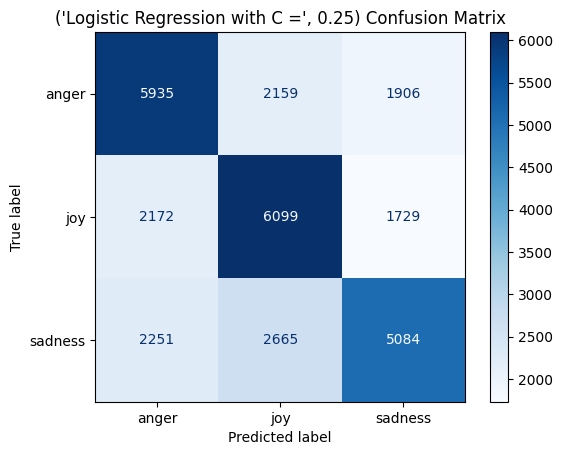

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


('Logistic Regression with C =', 0.5) Results
              precision    recall  f1-score   support

           0       0.57      0.59      0.58     10000
           1       0.56      0.61      0.58     10000
           2       0.58      0.51      0.54     10000

    accuracy                           0.57     30000
   macro avg       0.57      0.57      0.57     30000
weighted avg       0.57      0.57      0.57     30000



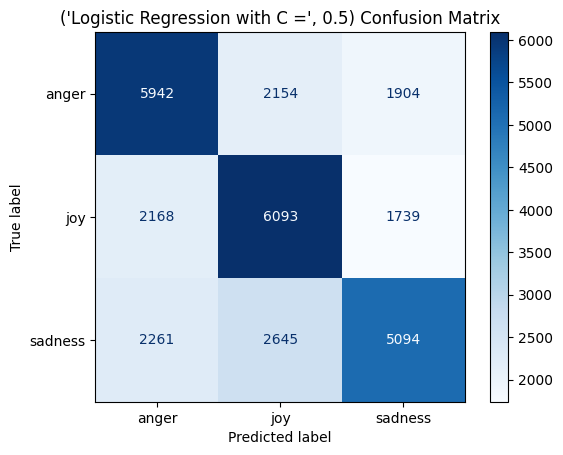

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


('Logistic Regression with C =', 0.75) Results
              precision    recall  f1-score   support

           0       0.57      0.59      0.58     10000
           1       0.56      0.61      0.58     10000
           2       0.58      0.51      0.54     10000

    accuracy                           0.57     30000
   macro avg       0.57      0.57      0.57     30000
weighted avg       0.57      0.57      0.57     30000



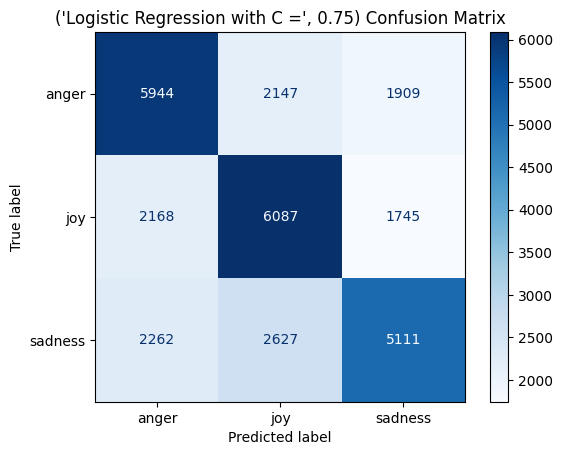

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


('Logistic Regression with C =', 1.0) Results
              precision    recall  f1-score   support

           0       0.57      0.59      0.58     10000
           1       0.56      0.61      0.58     10000
           2       0.58      0.51      0.54     10000

    accuracy                           0.57     30000
   macro avg       0.57      0.57      0.57     30000
weighted avg       0.57      0.57      0.57     30000



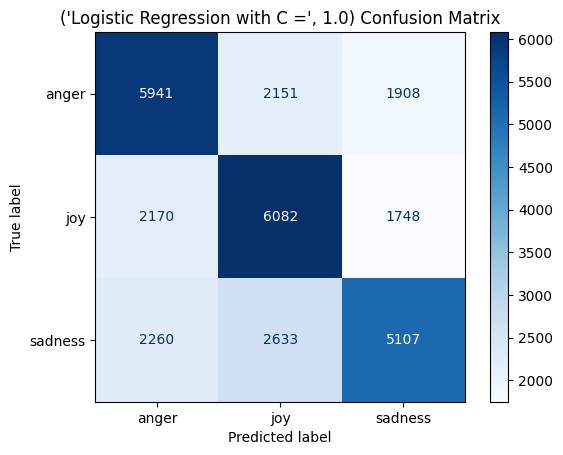

In [9]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Baseline Logistic Regression

for C in [0.25, 0.5, 0.75, 1.0]:
    logreg = LogisticRegression(
        multi_class='ovr',    
        solver='liblinear',
        max_iter=500,
        C=C,
        random_state=42,
    )
    y_pred_logreg = train_test_evaluate(logreg, model_name=("Logistic Regression with C =", C), visualize=True)

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Logistic Regression (Feature-augmented) Results
              precision    recall  f1-score   support

           0       0.57      0.59      0.58     10000
           1       0.56      0.61      0.58     10000
           2       0.58      0.51      0.54     10000

    accuracy                           0.57     30000
   macro avg       0.57      0.57      0.57     30000
weighted avg       0.57      0.57      0.57     30000



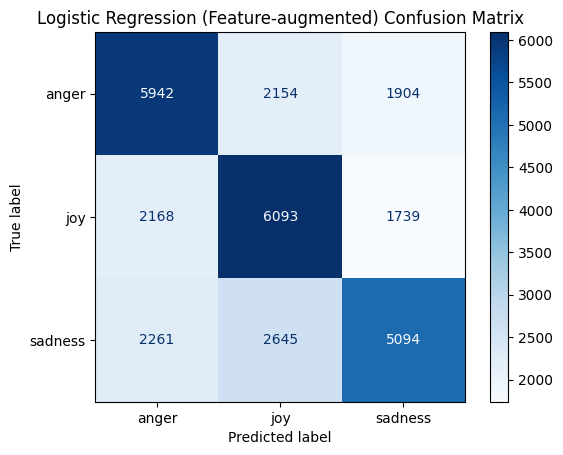

In [10]:
# feature augmented
logreg_poly = LogisticRegression(
    multi_class='ovr',
    solver='liblinear',
    max_iter=500,
    C=0.5,
    random_state=42
)

y_pred_logreg_poly = train_test_evaluate(logreg_poly, model_name="Logistic Regression (Feature-augmented)", visualize=True)

<h1>Polynomial Logistic Regression</h1>

In [ ]:
#TODO: polynomial logistic regression

<h1>Neural Network with Keras</h1>

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

num_features = X_train_final.shape[1]
num_classes = len(label_enc.classes_)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model = Sequential([
    Dense(256, activation='relu', input_shape=(num_features,)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),  # slightly smaller LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_final, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=512,
    callbacks=[early_stop],
)

y_proba = model.predict(X_test_final)
y_pred_nn = np.argmax(y_proba, axis=1)

print("Keras NN Classification Report:")
print(classification_report(y_test, y_pred_nn, target_names=label_enc.classes_))

cm_nn = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=label_enc.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Keras Neural Network Confusion Matrix")
plt.show()

ModuleNotFoundError: No module named 'tensorflow'

<h1>KNN</h1>

KNN Classifier Results
              precision    recall  f1-score   support

           0       0.41      0.52      0.45     10000
           1       0.36      0.35      0.35     10000
           2       0.41      0.30      0.35     10000

    accuracy                           0.39     30000
   macro avg       0.39      0.39      0.39     30000
weighted avg       0.39      0.39      0.39     30000



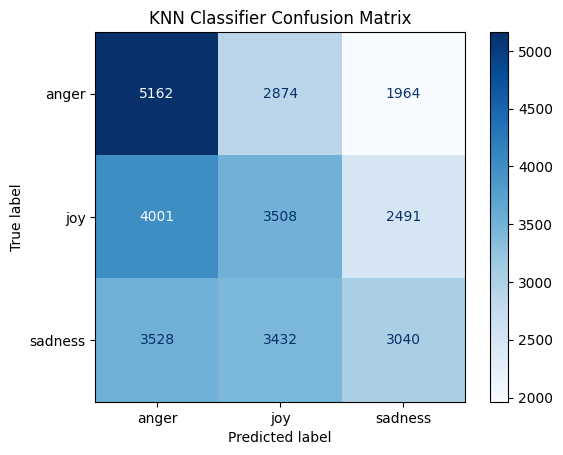

In [12]:
from sklearn.neighbors import KNeighborsClassifier
# run initial test with default hyperparameters
knn = KNeighborsClassifier(n_jobs=-1)
knn_pred = train_test_evaluate(knn, model_name="Base KNN Classifier", visualize=True)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': list(range(1, 31)),    
    'weights': ['uniform', 'distance'],      
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],  
    'p': [1, 2],                             
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  
}

knn = KNeighborsClassifier(n_jobs=-1)

# random search
random_search = RandomizedSearchCV(knn,
    param_distributions=param_grid,
    n_iter=50, 
    cv=5, 
    n_jobs=-1,  
    random_state=42
)

random_search.fit(X_train_final, y_train_final)

print("Best parameters (single RandomSearch):")
print(random_search.best_params_)

knn_best = KNeighborsClassifier(
    n_jobs=-1,
    **random_search.best_params_
)

y_pred_knn_random_best = train_test_evaluate(knn_best, visualize = True, model_name = "Best KNN Classifier (random search)")

# grid search
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
)

grid_search.fit(X_train_final, y_train_final)

print("Best parameters (single GridSearch):")
print(grid_search.best_params_)

knn_best = KNeighborsClassifier(
    n_jobs=-1,
    **grid_search.best_params_
)

y_pred_knn_grid_best = train_test_evaluate(knn_best, visualize = True, model_name = "Best KNN Classifier (grid search)")